# Notebook for analyzing expression of diagnostic genes in rnaSeq tpm data for 5GB1 bacteria 

Collaborators: 
* Vrishabhadev Sathish Kumar
* PI: Erin Wilson

Data files:
* RNA-seq output from barrelseq pipeline
* mapping from sample id to experiment condition
* diagnostic genes identified by Dr. Lidstrom

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import math

In [4]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/sample2condition.txt'
diagnostic_genes_file = 'data/diagnostic_genes.csv'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

# Parse and obtain usable dataframe of raw tpm
df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis = 1)

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
    sample2condition = dict(x.strip().split() for x in f.readlines())

# load the diagnostic genes data
df_diagnostics = pd.read_csv(diagnostic_genes_file)

In [41]:
list_conditions = list(set(sample2condition.values()))
list_conditions

['lowO2_fast_growth',
 'slow_growth',
 'lowO2_slow_growth',
 'highO2_slow_growth',
 'LanzaTech',
 'NoLanthanum',
 'NoCu',
 'unknown',
 'lowCH4',
 'aa3_KO',
 'MeOH',
 'crotonic_acid',
 'highCu',
 'WT_control',
 'WithLanthanum',
 'lowCu',
 'medCu',
 'NO3_lowO2_slow_growth',
 'uMax']

***
# Functions: 

## PairwiseScatter  --> Seaborn Scatterplot 

In [105]:
"""
Given two samples, plots a scatter plot of the genes'
expressions against each other in a pairwise manner

s1_name: sample 1 name
s2_name: sample 2 name
"""
def pairwise_scatter(s1_name, s2_name):
    plt.figure(figsize=(13, 12))

    s1 = df_all_samples_diag_genes[s1_name]
    s2 = df_all_samples_diag_genes[s2_name]

    labels = list(df_all_samples_diag_genes.T.columns)

    scatter = sns.scatterplot(x = s1, y = s2, s = 50, hue = labels)
    line = plt.plot([0,170],[0,170], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")

    plt.xlabel(s1_name, fontsize = 12)
    plt.ylabel(s2_name, fontsize = 12)

    plt.title("Pairwise Plot of Diagnostic Gene Expression for "  + s1_name +" and " + s2_name, fontsize = 13)

    plt.show()

***
## Diagnostic genes of interest

In [3]:
df_diagnostics

,Gene,Function,Diagnostic for
0,EQU24_RS14140,bacteriohemerythrin,O2-limitation
1,EQU24_RS17070,nifD; nitrogenase structural gene,N-limitation when also O2-limited
2,MBURv2_160514,heme synthesis,Fe-limitation
3,EQU24_RS01660,Mo transport (putative),Mo-limitation
4,EQU24_RS07680,CorA copper uptake,Cu-limitation
5,EQU24_RS01475,Mo-Formate DH subunit B,W-limitation


In [21]:
print("Genes not present in tpm data: ")
new_genes = []
for gene in df_diagnostics['Gene']:
    if gene not in df_raw_tpm.columns:
        new_genes.append(gene)
        print(gene)

Genes not present in tpm data: 
MBURv2_160514


In [28]:
df_clean_diagnostics = df_diagnostics[~df_diagnostics['Gene'].isin(new_genes)]
df_clean_diagnostics

,Gene,Function,Diagnostic for
0,EQU24_RS14140,bacteriohemerythrin,O2-limitation
1,EQU24_RS17070,nifD; nitrogenase structural gene,N-limitation when also O2-limited
3,EQU24_RS01660,Mo transport (putative),Mo-limitation
4,EQU24_RS07680,CorA copper uptake,Cu-limitation
5,EQU24_RS01475,Mo-Formate DH subunit B,W-limitation


***

## Pair-wise Scatterplots of Diagnostic Gene Expression Between Samples of Same Condition

### Details: 
* 
*
*

In [133]:
df_all_samples_diag_genes = df_raw_tpm[df_clean_diagnostics['Gene']]

df_all_samples_diag_genes = df_all_samples_diag_genes.T
df_all_samples_diag_genes

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS14140,28.603246,91.736391,126.615893,133.906122,190.223530,227.676228,12.195826,11.991596,12.707627,10.781432,...,38.911948,44.422399,1656.111935,1323.221454,1716.583597,831.997500,2179.236637,2009.804320,2444.914424,1353.895412
EQU24_RS17070,4.516511,4.915427,1.415161,4.706019,5.733278,6.482568,3.777780,3.216665,3.962612,3.874251,...,9.092900,7.452042,23.727795,32.180850,22.646416,51.485082,33.219206,30.819280,28.186233,21.973230
EQU24_RS01660,0.880606,0.808484,10.409731,12.292511,8.715799,13.301575,13.011242,12.239857,13.163323,12.523269,...,30.170638,22.602789,115.948007,160.704714,118.818740,119.488719,144.219179,108.509206,93.315421,82.055940
EQU24_RS07680,11.813370,18.035879,705.284978,695.267919,981.369041,1096.568169,311.417699,308.519000,320.985003,318.935528,...,1154.910241,1260.065707,211.770928,278.320377,262.069293,337.307671,205.812733,216.719319,239.090549,323.579876
EQU24_RS01475,156.100482,166.467163,710.925836,679.184146,691.719622,870.471342,718.889408,712.968817,736.415121,731.392990,...,564.000364,521.508289,627.650964,747.442530,863.022672,553.101306,465.629865,573.838592,588.255962,795.488439


In [137]:
df_sorted_samples_diag_genes = (df_all_samples_diag_genes
                       .stack()
                    .reset_index())


df_sorted_samples_diag_genes.columns = ['locus_tag','sample_name','tpm_value']

df_sorted_samples_diag_genes["condition"] = df_sorted_samples_diag_genes["sample_name"].apply(lambda x: sample2condition.get(x))

df_sorted_samples_diag_genes.sort_values("condition")
df_sorted_samples_diag_genes

,locus_tag,sample_name,tpm_value,condition
0,EQU24_RS14140,5GB1_ferm_Ack_QC_tpm,28.603246,lowO2_slow_growth
1,EQU24_RS14140,5GB1_ferm_WT_QC_tpm,91.736391,lowO2_slow_growth
2,EQU24_RS14140,5GB1_FM03_TR1_QC_tpm,126.615893,uMax
3,EQU24_RS14140,5GB1_FM03_TR2_QC_tpm,133.906122,uMax
4,EQU24_RS14140,5GB1_FM11_TR1_QC_tpm,190.223530,lowO2_fast_growth
...,...,...,...,...
485,EQU24_RS01475,5GB1C-5G-N-BR2_tpm,553.101306,NoLanthanum
486,EQU24_RS01475,5GB1C-JG15-La-BR1_tpm,465.629865,WithLanthanum
487,EQU24_RS01475,5GB1C-JG15-La-BR2_tpm,573.838592,WithLanthanum
488,EQU24_RS01475,5GB1C-JG15-N-BR1_tpm,588.255962,NoLanthanum


In [123]:
df_all_samples_diag_genes.pivot('locus_tag', 'sample_name', 'tpm_value')

sample_name,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_latelog_vial_TR2_QC_tpm,5GB1_FM03_TR1_QC_tpm,...,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1_vial_wLa_TR3_tpm,5GB1_vial_woLa_TR2_tpm,br1_QC_tpm,br2_QC_tpm,ribo0_tpm,total_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS01475,627.650964,747.442530,863.022672,553.101306,465.629865,573.838592,588.255962,795.488439,313.219877,710.925836,...,156.100482,166.467163,564.000364,521.508289,414.945697,434.300356,224.329188,281.731749,397.637831,505.379849
EQU24_RS01660,115.948007,160.704714,118.818740,119.488719,144.219179,108.509206,93.315421,82.055940,428.158960,10.409731,...,0.880606,0.808484,30.170638,22.602789,7.487129,8.570756,41.949677,29.505835,8.767254,0.000000
EQU24_RS07680,211.770928,278.320377,262.069293,337.307671,205.812733,216.719319,239.090549,323.579876,170.957232,705.284978,...,11.813370,18.035879,1154.910241,1260.065707,242.923735,509.828385,27.326903,49.930144,525.479515,560.541879
EQU24_RS14140,1656.111935,1323.221454,1716.583597,831.997500,2179.236637,2009.804320,2444.914424,1353.895412,4107.521280,126.615893,...,28.603246,91.736391,38.911948,44.422399,3348.000393,3738.060115,6.450966,7.967075,20.427036,19.628794
EQU24_RS17070,23.727795,32.180850,22.646416,51.485082,33.219206,30.819280,28.186233,21.973230,111.538463,1.415161,...,4.516511,4.915427,9.092900,7.452042,14.928392,26.440158,10.006388,12.576094,4.679500,2.632646


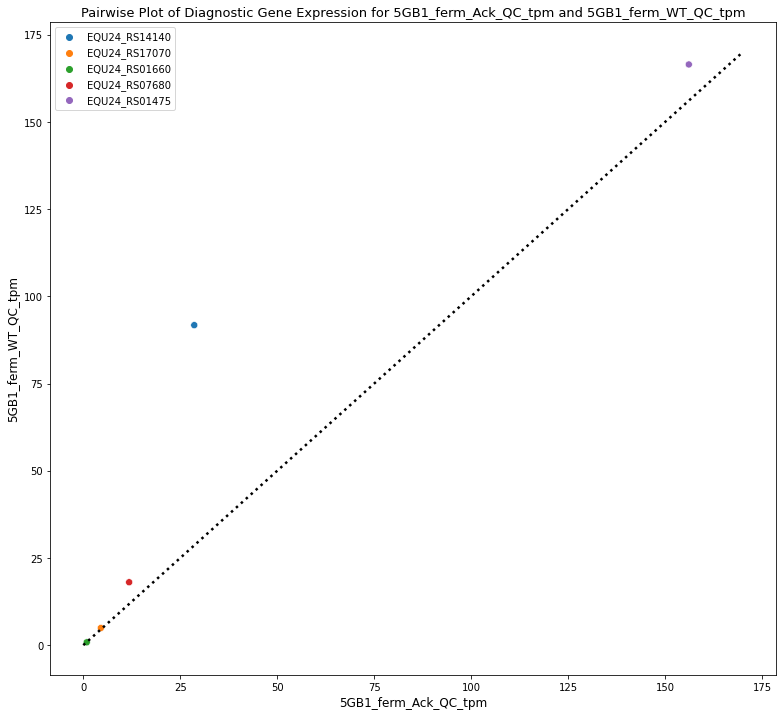

In [106]:
s1_name =  "5GB1_ferm_Ack_QC_tpm"
s2_name = "5GB1_ferm_WT_QC_tpm"

pairwise_scatter(s1_name, s2_name)

In [ ]:
sns.pairplot(df_all_samples_diag_genes.T, vars=df_all_samples_diag_genes.T.columns)